# 【問題1】BoWとN-gram(手計算)

In [28]:
import pandas as pd
import numpy as np
import re
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.charfilter import *
from janome.tokenfilter import *
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from nltk import word_tokenize, FreqDist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, GRU, Embedding, Input
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils, to_categorical
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models


In [8]:
# 例
import pandas as pd

vocabulary = ["I", "love", "this", "is", "the", "baseball"]
ms_kk_texts = ["I love baseball !!", "I love this !"]
texts_vec = [[1,1,0,0,0,1], [1,1,1,0,0,0]]

df_bow_1gram = pd.DataFrame(data = texts_vec, columns = vocabulary, index = ms_kk_texts)
df_bow_1gram

,I,love,this,is,the,baseball
I love baseball !!,1,1,0,0,0,1
I love this !,1,1,1,0,0,0


In [33]:
vocabulary1 = ["今", "撮影", "中", "です", "休憩", "ドラマ", "映画", "瞬","公開","今日"]
ms_kk_texts = ["今撮影中で〜す！", "今休憩中で〜す(^^)", "今日ドラマ撮影で〜す！", "今日、映画瞬公開で〜す！！！"]
texts_vec = [[1,1,1,1,0,0,0,0,0,0], [1,0,1,1,1,0,0,0,0,0],[0,1,0,1,0,1,0,0,0,1],[0,0,0,1,0,0,1,1,1,1]]

df_bow_1gram = pd.DataFrame(data = texts_vec, columns = vocabulary1, index = ms_kk_texts)
df_bow_1gram

,今,撮影,中,です,休憩,ドラマ,映画,瞬,公開,今日
今撮影中で〜す！,1,1,1,1,0,0,0,0,0,0
今休憩中で〜す(^^),1,0,1,1,1,0,0,0,0,0
今日ドラマ撮影で〜す！,0,1,0,1,0,1,0,0,0,1
今日、映画瞬公開で〜す！！！,0,0,0,1,0,0,1,1,1,1


In [34]:
vocabulary2 = ["今撮影", "撮影中", "中です", "今休憩", "休憩中", "今日ドラマ","ドラマ撮影","撮影です", "今日映画","映画瞬", "瞬公開","公開です"]
ms_kk_texts = ["今撮影中で〜す！", "今休憩中で〜す(^^)", "今日ドラマ撮影で〜す！", "今日、映画瞬公開で〜す！！！"]
texts_vec = [[1,1,1,0,0,0,0,0,0,0,0,0], [0,0,1,1,1,0,0,0,0,0,0,0],[0,0,0,0,0,1,1,1,0,0,0,0],[0,0,0,0,0,0,0,0,1,1,1,1]]

df_bow_2gram = pd.DataFrame(data = texts_vec, columns = vocabulary2, index = ms_kk_texts)
df_bow_2gram

,今撮影,撮影中,中です,今休憩,休憩中,今日ドラマ,ドラマ撮影,撮影です,今日映画,映画瞬,瞬公開,公開です
今撮影中で〜す！,1,1,1,0,0,0,0,0,0,0,0,0
今休憩中で〜す(^^),0,0,1,1,1,0,0,0,0,0,0,0
今日ドラマ撮影で〜す！,0,0,0,0,0,1,1,1,0,0,0,0
今日、映画瞬公開で〜す！！！,0,0,0,0,0,0,0,0,1,1,1,1


# 【問題2】TF-IDF(手計算)

In [30]:
df_bow_1gram

,今,撮影,中,です,休憩,ドラマ,映画,瞬,公開,今日
今撮影中で〜す！,1,1,1,1,0,0,0,0,0,0
今休憩中で〜す(^^),1,0,1,1,1,0,0,0,0,0
今日ドラマ撮影で〜す！,0,1,0,1,0,1,0,0,0,1
今日、映画瞬公開で〜す！！！,0,0,0,1,0,0,1,1,1,1


In [38]:
tf_arr = df_bow_1gram.values / df_bow_1gram.sum(axis=1).values.reshape(-1,1)
idf_arr = np.log2(len(df_bow_1gram) / df_bow_1gram.sum(axis=0)).values
tf_idf_df = pd.DataFrame(tf_arr * idf_arr, index=ms_kk_texts, columns=vocabulary1)
tf_idf_df

,今,撮影,中,です,休憩,ドラマ,映画,瞬,公開,今日
今撮影中で〜す！,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00
今休憩中で〜す(^^),0.25,0.00,0.25,0.0,0.5,0.0,0.0,0.0,0.0,0.00
今日ドラマ撮影で〜す！,0.00,0.25,0.00,0.0,0.0,0.5,0.0,0.0,0.0,0.25
今日、映画瞬公開で〜す！！！,0.00,0.00,0.00,0.0,0.0,0.0,0.4,0.4,0.4,0.20


# 【問題3】テキストクリーニング(プログラミング)

```<!everyone> *【スペシャル特典】有償のRubyMineやPyCharmの `6ヶ月間100%OFFクーポン` をご希望者の方先着100名様に贈呈いたします！*\n\nこの度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、100クーポンをいただくことができました。\n\n```\nRubyMine\n<https://www.jetbrains.com/ruby/>\n\nPyCharm\n<https://www.jetbrains.com/pycharm/>\n```\n\n「ご希望の方は、手を挙げて！」方式で、ご希望の方はこの投稿の手あげスタンプをクリックしてください。\n\n期限は、 *`2019年3月20日（水）22:00まで`* とさせていただきます。\nふるってのご希望をお待ちしております！ :smile:```

【問】
このテキストに以下の処理を施してください。

urlを削除
【〇〇】を削除
改行等の特殊文字を削除
絵文字除去

In [92]:
# 正規表現操作のライブラリ
import re
# 対象テキストデータ
text = '''
<!everyone> *【スペシャル特典】有償のRubyMineやPyCharmの`6ヶ月間100%OFFクーポン` 
をご希望者の方先着100名様に贈呈いたします！*\n\n
この度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、
100クーポンをいただくことができました。\n\n```\nRubyMine\n<https://www.jetbrains.com/ruby/>\n\n
PyCharm\n<https://www.jetbrains.com/pycharm/>\n```\n\n「ご希望の方は、手を挙げて！」方式で、ご希望の方は
この投稿の手あげスタンプをクリックしてください。\n\n期限は、 *`2019年3月20日（水）22:00まで`* とさせていただきます。\n
ふるってのご希望をお待ちしております！ :smile:
'''

# 正規表現一覧
symbol_reg = r'[\n*` ]+'
mention_reg = r'<.*?>'
phraze_reg = r'【.*?】'
command_reg = r':[^0-9０-９]+:'

reg_str = f'{symbol_reg}|{mention_reg}|{phraze_reg}|{command_reg}'
reg_str = re.compile(reg_str)
re.sub(reg_str,'',text)

'有償のRubyMineやPyCharmの6ヶ月間100%OFFクーポンをご希望者の方先着100名様に贈呈いたします！この度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、100クーポンをいただくことができました。RubyMinePyCharm「ご希望の方は、手を挙げて！」方式で、ご希望の方はこの投稿の手あげスタンプをクリックしてください。期限は、2019年3月20日（水）22:00までとさせていただきます。ふるってのご希望をお待ちしております！'

# 【問題4】形態素解析

上記のクリーニングしたテキストをJanomeを用いて形態素解析をし、
名詞または動詞の単語を抜き出してください。

In [114]:
from janome.tokenizer import Tokenizer
t = Tokenizer()
token_list = []
for token in t.tokenize(re.sub(reg_str,'',text)):
    if token.part_of_speech.split(',')[0] == ('名詞' or '動詞'):
        token_list.append(token.surface)

In [116]:
print(token_list)

['有償', 'RubyMine', 'PyCharm', '6', 'ヶ月', '間', '100', '%', 'OFF', 'クーポン', '希望', '者', '方', '先着', '100', '名', '様', '贈呈', '度', 'RubyMine', 'PyCharm', 'メーカー', 'JetBrains', '社', 'クーポン', 'コード', '提供', '交渉', '100', 'クーポン', 'こと', 'RubyMinePyCharm', '希望', '方', '手', '方式', '希望', '方', '投稿', '手', 'スタンプ', 'クリック', '期限', '2019', '年', '3', '月', '20', '日', '水', '22', ':', '00', '希望', 'お待ち']


# 【問題5】ニュースの分析

**目的**  
  
日本語の自然言語処理の体験  
類似度の理解

- まずどんなニュースなのか読んでみる
- 出現単語をカウントして分析する
- テキストをクリーニングする
- BoW + TFIDFでベクトル化する
- あるニュースに一番cos類似度が近いニュースを出力する関数の作成
- 別の類似度手法を1つ調べて上の関数に組み込む(切り替えられるようにする)
- なぜそのような結果になったのか考察する

In [1]:
# livedoorのnewsをダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
# 圧縮ファイルを解凍
!tar zxf ldcc-20140209.tar.gz
# livedoorニュースの説明を表示
!cat text/README.txt

--2019-07-30 12:11:02--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  4.50MB/s    in 1.9s    

2019-07-30 12:11:05 (4.50 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]

livedoor ニュースコーパス


概要
-----------------
本コーパスは、NHN Japan株式会社が運営する「livedoor ニュース」のうち、下記のクリエイティブ・コモンズ
ライセンスが適用されるニュース記事を収集し、可能な限りHTMLタグを取り除いて作成したものです。

- トピックニュース
  http://news.livedoor.com/category/vender/news/
- Sports Watch
  http://news.livedoor.com/category/vender/208/
- ITライフハック
  http://news.livedoor.com/category/vender/223/
- 家電チャンネル
  http://news.livedoor.com/category/vender/kadench/
- MOVIE ENTER
  http://news.livedoor.com/category/vender/movie_enter/
- 独女通信
  http://news

In [62]:
# サブフォルダまで賢く読み込んでもらう
from sklearn.datasets import load_files
# encodingをutf-8指定して読み込み
bin_data = load_files('./text', encoding='utf-8')
documents = bin_data.data
# 今回はラベルが無いと仮定してください
# targets = bin_data.target

とりあえずどんなデータか読んで見る。

In [67]:
# textを抽出する
news_text = ""

In [68]:
for i in range(len(documents)):
    news_text += documents[i]

In [69]:
documents[:2]

['http://news.livedoor.com/article/detail/4931238/\n2010-08-08T10:00:00+0900\nNY名物イベントが日本でも！名店グルメを気軽に楽しむ\nニューヨークで20年続いている食の祭典「レストラン・ウィーク」。その日本版がダイナーズクラブ特別協賛のもと7月30日よりスタート。8月31日までの期間中、青山・六本木、丸の内、銀座、横浜のエリアから、ラグジュアリーレストラン81店舗がこのイベントのために特別用意したランチメニュー2010円（税・サ別）、ディナー5000円（税・サ別）を気軽に楽しめる、とっておきのイベントです。\n\u3000\n\u3000実行委員長には、学校法人服部学園、服部栄養専門学校 理事長・校長であり医学博士でもある服部幸應氏を迎え、実行委員に石田純一さん、LA BETTOLAオーナーシェフ落合務氏、フードアナリスト協会会長、高賀右近氏、つきぢ田村三代目、田村隆氏に、そして放送作家・脚本家の小山薫堂さんなど、食のスペシャリストたちが勢揃い。\n\n参加レストランには、ミシュランのフランス版、東京版ともに星を獲得している吉野建シェフの「レストラン タテル ヨシノ 汐留」や、日本料理の名門「つきぢ田村」、「金田中 庵」、「赤坂璃宮」に「mikuni MARUNOUCHI」など、日本を代表するレストランがずらり。\n\u3000イベント期間の〜8月19日までは、特別協賛のダイナーズクラブカード会員、またはシティバンクに口座を持つシティゴールドメンバーが楽しめる先行期間となりますが、その後は誰でも参加できるので、日程のチェックは必須。\n\n\u3000予約方法は必ず事前に、各店舗に問合せを行い「ジャパンレストラン・ウィーク2010」での予約であることを伝えればOK！憧れていたレストランの料理をリーズナブルにいただけるチャンスです！極上の味とラグジュアリーな空間を満喫。そんな幸せを実感できる「ジャパンレストラン・ウィーク2010」にぜひ参加しててみてはいかがですか？\n\nJAPAN RESTAURANT WEEK 2010 -公式サイト\n',
 'http://news.livedoor.com/article/detail/6655079/\n2012-06-13T19:25:00+0

In [64]:
from janome.tokenizer import Tokenizer
import collections

t = Tokenizer()

In [70]:
# 単語をカウントする
c = collections.Counter(t.tokenize(news_text, wakati=True))

In [71]:
# 出現頻度が高い順に表示
mc = c.most_common()
print(mc[:20])

[('の', 207059), ('、', 206233), ('。', 136138), ('に', 131630), ('を', 126780), ('が', 116333), ('は', 112063), ('て', 101450), ('で', 84560), ('た', 83900), ('\n', 83135), (' ', 79600), ('と', 76650), ('「', 63160), ('」', 62505), ('し', 62486), ('\n\n', 51576), ('も', 47548), ('・', 41657), ('な', 36142)]


- （予想通りではあるが）助詞や改行文字の出現頻度が高い。

In [72]:
# URLを削除
regex_1 = re.compile(r"http(s)?://([\w-]+\.)+[\w-]+(/[\w ./?%&=]*)?")

# \\n\\u3000
regex_3 = re.compile("\\n(?:\\u3000)?")

# 時刻
regex_2 = re.compile(r"201(?:\d-\d-\d\S\d\d:\d\d|\d-\d\d-\d\d\S\d\d:\d\d):\d\d\+0900")

# 正規表現まとめ
regexes = [regex_1, regex_2, regex_3]

In [73]:
# テキストクリーニング後のテキスト
re_documents = []

for i in range(len(documents)):
    tmp = documents[i]
    tmp = regex_1.sub("", tmp)
    tmp = regex_2.sub("", tmp)
    tmp = regex_3.sub("", tmp)
    re_documents.append(tmp)

In [74]:
re_documents[:3]

['NY名物イベントが日本でも！名店グルメを気軽に楽しむニューヨークで20年続いている食の祭典「レストラン・ウィーク」。その日本版がダイナーズクラブ特別協賛のもと7月30日よりスタート。8月31日までの期間中、青山・六本木、丸の内、銀座、横浜のエリアから、ラグジュアリーレストラン81店舗がこのイベントのために特別用意したランチメニュー2010円（税・サ別）、ディナー5000円（税・サ別）を気軽に楽しめる、とっておきのイベントです。実行委員長には、学校法人服部学園、服部栄養専門学校 理事長・校長であり医学博士でもある服部幸應氏を迎え、実行委員に石田純一さん、LA BETTOLAオーナーシェフ落合務氏、フードアナリスト協会会長、高賀右近氏、つきぢ田村三代目、田村隆氏に、そして放送作家・脚本家の小山薫堂さんなど、食のスペシャリストたちが勢揃い。参加レストランには、ミシュランのフランス版、東京版ともに星を獲得している吉野建シェフの「レストラン タテル ヨシノ 汐留」や、日本料理の名門「つきぢ田村」、「金田中 庵」、「赤坂璃宮」に「mikuni MARUNOUCHI」など、日本を代表するレストランがずらり。イベント期間の〜8月19日までは、特別協賛のダイナーズクラブカード会員、またはシティバンクに口座を持つシティゴールドメンバーが楽しめる先行期間となりますが、その後は誰でも参加できるので、日程のチェックは必須。予約方法は必ず事前に、各店舗に問合せを行い「ジャパンレストラン・ウィーク2010」での予約であることを伝えればOK！憧れていたレストランの料理をリーズナブルにいただけるチャンスです！極上の味とラグジュアリーな空間を満喫。そんな幸せを実感できる「ジャパンレストラン・ウィーク2010」にぜひ参加しててみてはいかがですか？JAPAN RESTAURANT WEEK 2010 -公式サイト',
 '小沢一郎氏の妻が支援者に離婚を報告。「週刊文春」報じる13日、Web版「週刊文春」は、民主党の元代表・小沢一郎氏の妻が、支援者宛に離婚したことを伝える手紙を送ったと報じ、ツイッターやネット掲示板で大きな話題になっている。記事によると、その手紙は「小沢は放射能が怖くて秘書と一緒に逃げだしました」「隠し子が発覚した際、小沢元代表は和子夫人に謝るどころか、『いつでも離婚してやる』と言い放ち

In [75]:
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer as TV

In [76]:
# 200本に1本
cv = CV(min_df=0.001)

In [77]:
matrix = cv.fit_transform(re_documents)

In [78]:
matrix.shape

(7376, 5244)

In [79]:
X1 = matrix.toarray()

In [80]:
X1.shape

(7376, 5244)

In [81]:
tv = TV(min_df=0.001)

In [82]:
tfidf = tv.fit_transform(re_documents)

In [83]:
X2 = matrix.toarray()
X2.shape

(7376, 5244)

**あるニュースに一番cos類似度が近いニュースを出力する関数の作成**

In [85]:
from sklearn.metrics.pairwise import cosine_similarity
cos = cosine_similarity(X1, X1)

In [86]:
cos[0].argsort()[-2]

3032

In [102]:
import Levenshtein

In [89]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_news(index, texts, mode="cos"):
    """
    最もコサイン類似度が近いテキストを出力する関数

    Parameters
    ---------
    index : int
    類似度を評価するテキストのインデックス

    word_vec : 次の形のndarray, shape(samples)
    単語ベクトル

    texts : list
    テキスト

    mode : str
    コサイン類似度（cos） or 
    """

    if mode == "cos":
        word_vec = CV(min_df=0.001).fit_transform(texts).toarray() # 単語ベクトルに変換（BoW)
        cos_matrix = cosine_similarity(word_vec, word_vec) # コサイン類似度のマトリックス
        cos_similarity = cos_matrix[index]  #コサイン類似度
        similar_text_index = cos_similarity.argsort()[-2] # 類似度が最も近いテキストのインデックス（自身との類似度が最大なので2番目のインデックスを取る）
        return texts[similar_text_index]

    elif mode == "lev":
        distances = np.zeros(len(texts))

    # 指定したテキストと他のテキスト間のレーベンシュタイン距離を計算する
    for i in range(len(texts)):
        distances[i] = Levenshtein.distance(texts[index], texts[i])

    similar_text_index = distances.argsort()[-2]

    return texts[similar_text_index]

In [97]:
!pip install python-Levenshtein

**類似テキストの探索（コサイン類似度）**

In [98]:
# 類似度を測りたいテキストのインデックス
target = 2

In [99]:
# 類似度の高い記事
similar_cos = find_similar_news(target, re_documents)

In [100]:
print(similar_cos)
print(re_documents[target])

【Sports Watch】三浦ファン、ほしのあきを“さげまん”呼ばわり22日（月）発売の「週刊アサヒ芸能」（12.2号）では、「ほしのあき 三浦皇成結婚を阻む『さげまんボディ』『スランプの責任を押し付けられて…』」との見出しで、騎手・三浦皇成とグラビアタレント・ほしのあきの交際について、その周辺レポートを掲載した。新人年間最多勝（91勝）に最速100勝を挙げた次世代のスーパージョッキーだが、近年、失速感は否めない戦績に終始している。同誌にコメントを寄せるスポーツ紙のデスクは、「今の三浦は、もう『武豊2世』じゃない。G1制覇と言っても、そのクラスのお手馬は数頭だけ。代役で一発という寂しい状況です」と語っており、美浦TC関係者も「昨年9月、英国で初騎乗初勝利するも、ほしのとの交際が1年目を迎えて、状況が一変した。恩師の河野通文調教師と袂を分かち、フリー宣言をしてから急降下。今年1月の落馬事故も影響し、東西リーディング29位（11月14日現在）と低迷している。三浦ファンがほしのを“さげまん”と呼ぶ気持ちも納得できます」と話している。また、二人の来春結婚の噂について、前出のデスクは、「三浦の両親が最後の難関でしょう。父親との絆が深く、通常では考えられないフリー宣言を勧めたのも両親と聞いています。その父親が13歳の年の差婚をすんなりと認めてくれるかどうか…」という見解を示しており、すんなりとはいきそうにない現状をうかがわせた。・週刊アサヒ芸能 ［ライト版］＜デジタル＞（PC版）・週刊アサヒ芸能（モバイル版）
【Sports Watch】田中＆里田の交際、アプローチは里田からグラビアアイドル・ほしのあき＆騎手・三浦皇成がお互いのブログで交際を認めた日、東北楽天ゴールデンイーグルスのエース・田中将大とタレント・里田まいの交際もまた公のものとなったが、本日30日（火）発売の「週刊アサヒ芸能」（12.9号）では、「マー君を“ナンパ”した里田」との見出しで、両者の交際にまつわる関係者の証言を紹介した。同誌にコメントを寄せた芸能デスクによると、「周囲の事情はさておき、当人たちが盛り上がっているのは確か。結婚も完全に視野に入れているようで、すでに新居を探しているとの話まである」という。また、二人の交際は里田からのアプローチによるものとのことで、前出の芸能デスクは、「2人は昨年末の番組共演

- **両記事ともに恋愛関係であり、＜交際＞という単語が含まれていることからも、類似度が高いと判定されていると思われる。**

In [103]:
# 類似度の高い記事
similar_lev = find_similar_news(target, re_documents, mode="lev")

In [104]:
similar_lev

'iPhone女子部がフリーペーパー「iPhone♡」を大手量販店やソフトバンクショップで配布開始iPhone女子に向けた「iPhone♡」ができました！ iPhone女子部は、フリーペーパー「iPhone♡(アイフォーン ラブ)」を31日から大手量販店やソフトバンクショップの店舗で配布を開始した。iPhoneを利用する女性向けにiPhoneの便利な活用法やアプリの紹介、周辺機器やグッズの紹介などを32ページに渡って紹介している。発行部数は10万部。iPhone女子部発足のきっかけになったムック本『はじめまして。iPhone』以降、2011年2月配布のフリーペーパー『こんにちは、iPhone』、同年9月配布のフリーペーパー第2弾『ごきげんよう。iPhone』に続いてフリーペーパ第3弾となるiPhone♡は定期刊行していく予定だという。iPhone♡創刊号の表紙iPhone女子部のサイトで知らせている配布店舗は以下の通り。【ヨドバシカメラ】ソフトバンクヨドバシ梅田／ソフトバンクヨドバシＡＫＩＢＡ／ソフトバンクヨドバシ横浜／ソフトバンクヨドバシ京都／ソフトバンクステージヨドバシ新宿西口本店／ソフトバンクヨドバシ吉祥寺／ソフトバンクステージヨドバシ川崎／ソフトバンクステージヨドバシ町田／ソフトバンクヨドバシカメラ博多／ソフトバンクステージヨドバシ錦糸町／ソフトバンクヨドバシ札幌／ソフトバンクステージヨドバシ仙台／ソフトバンクステージヨドバシ千葉／ソフトバンクステージヨドバシ新宿東口ケータイ総合館／ソフトバンクステージヨドバシ上野／ソフトバンクステージヨドバシ京急上大岡（９階）／株式会社ヨドバシカメラマルチメディア宇都宮／株式会社ヨドバシカメラ八王子店Ｍ１【ヤマダ電機】ＬＡＢＩ\u3000１\u3000日本総本店\u3000池袋／ソフトバンクステージＬＡＢＩ新宿東口館／ＬＡＢＩ\u3000渋谷店／ソフトバンクステージＬＡＢＩ新宿西口／ソフトバンクステージＬＡＢＩ１モバイルドリーム館／ソフトバンクＬＡＢＩ１ＮＡＭＢＡ／ソフトバンクステージＬＡＢＩ品川大井町／ソフトバンクステージＬＡＢＩ１高崎／ソフトバンクステージＬＡＢＩ三宮／ソフトバンクステージＬＡＢＩ上大岡／テックランド坂戸店／ソフトバンクステージＬＡＢＩ千里／ソフトバンクステージＬＡＢＩ津田沼／テックランドＮｅｗ港北セン

# 【問題6】感情分析

In [43]:
vocab_size = 10000 # 出現頻度の順に10000個を取得
features = 16 # 埋め込む空間

In [44]:
# IMDB datasetのダウンロード
imdb = tf.keras.datasets.imdb

# 訓練データ中に出てくる単語のうち、最も頻繁に出現吸える10,000個を保持する
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

17465344/17464789 [==============================] - 0s 0us/step


In [45]:
print("train_data_type : {}".format(type(train_data)))
print("len : {}".format(len(train_data)))
print("")
print("test_data_type : {}".format(type(test_data)))
print("len : {}".format(len(test_data)))

train_data_type : <class 'numpy.ndarray'>
len : 25000

test_data_type : <class 'numpy.ndarray'>
len : 25000


In [46]:
# 単語をIDに変換する辞書
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [47]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [48]:
# インデックスの最初の方は予約済み
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [49]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding="post",
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding="post",
                                                       maxlen=256)

In [50]:
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, 64)) # 単語埋め込み
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 641,057
Trainable params: 641,057
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [52]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [53]:
history = model.fit(partial_x_train, partial_y_train,
                     epochs=40,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 12s 818us/sample - loss: 0.6030 - acc: 0.7008 - val_loss: 0.4188 - val_acc: 0.8347
Epoch 2/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.2932 - acc: 0.8869 - val_loss: 0.2896 - val_acc: 0.8838
Epoch 3/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.1796 - acc: 0.9347 - val_loss: 0.2900 - val_acc: 0.8864
Epoch 4/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.1192 - acc: 0.9619 - val_loss: 0.3291 - val_acc: 0.8793
Epoch 5/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.0844 - acc: 0.9762 - val_loss: 0.3748 - val_acc: 0.8766
Epoch 6/40
15000/15000 [==============================] - 1s 37us/sample - loss: 0.0578 - acc: 0.9868 - val_loss: 0.4211 - val_acc: 0.8719
Epoch 7/40
15000/15000 [==============================] - 1s 36us/

In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [57]:
import matplotlib.pyplot as plt

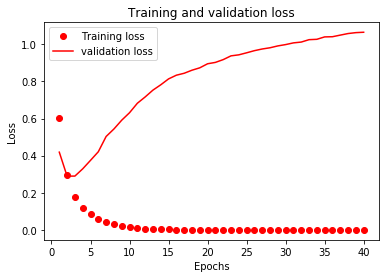

In [61]:
# ロス、正解率を可視化する

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

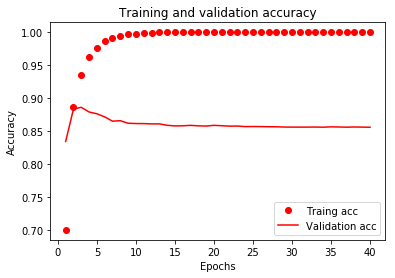

In [60]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc, "ro", label="Traing acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 【問題8】自然言語処理の応用事例
目的

NLPの情報共有 現在自然言語処理はどのような企業でどのように活用されているか？
1つ例をあげて3~5分で発表してください。

Gunosyでは自然言語処理を用いて記事を政治やスポーツ等に、分類しており各ユーザーに適している記事を配信しているらしい。